### This notebook is to use pre-trained Resnet50 to train a small subset of data to test baseline. Training ins with Internet on to be able to download the pre-trained model.

In [1]:
import os
import numpy as np
import pandas as pd 
from PIL import Image

from fastai import *
from fastai.vision.all import *
from fastai.callback import *

In [2]:
path = Path("../input")
data_path = path/'plant-pathology-2021-fgvc8'

In [3]:
df = pd.read_csv(data_path/'train.csv', low_memory=False)
df

image                           labels
0      800113bb65efe69e.jpg                          healthy
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2      80070f7fb5e2ccaa.jpg                             scab
3      80077517781fb94f.jpg                             scab
4      800cbf0ff87721f8.jpg                          complex
...                     ...                              ...
18627  fffb900a92289a33.jpg                          healthy
18628  fffc488fa4c0e80c.jpg                             scab
18629  fffc94e092a59086.jpg                             rust
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot
18631  fffe472a0001bd25.jpg                          healthy

[18632 rows x 2 columns]

In [4]:
df.labels.value_counts(dropna=False), df.labels.value_counts(dropna=False).unique()

(scab                               4826
 healthy                            4624
 frog_eye_leaf_spot                 3181
 rust                               1860
 complex                            1602
 powdery_mildew                     1184
 scab frog_eye_leaf_spot             686
 scab frog_eye_leaf_spot complex     200
 frog_eye_leaf_spot complex          165
 rust frog_eye_leaf_spot             120
 rust complex                         97
 powdery_mildew complex               87
 Name: labels, dtype: int64,
 array([4826, 4624, 3181, 1860, 1602, 1184,  686,  200,  165,  120,   97,
          87]))

In [5]:
total = df.labels.value_counts(dropna=False).sum()

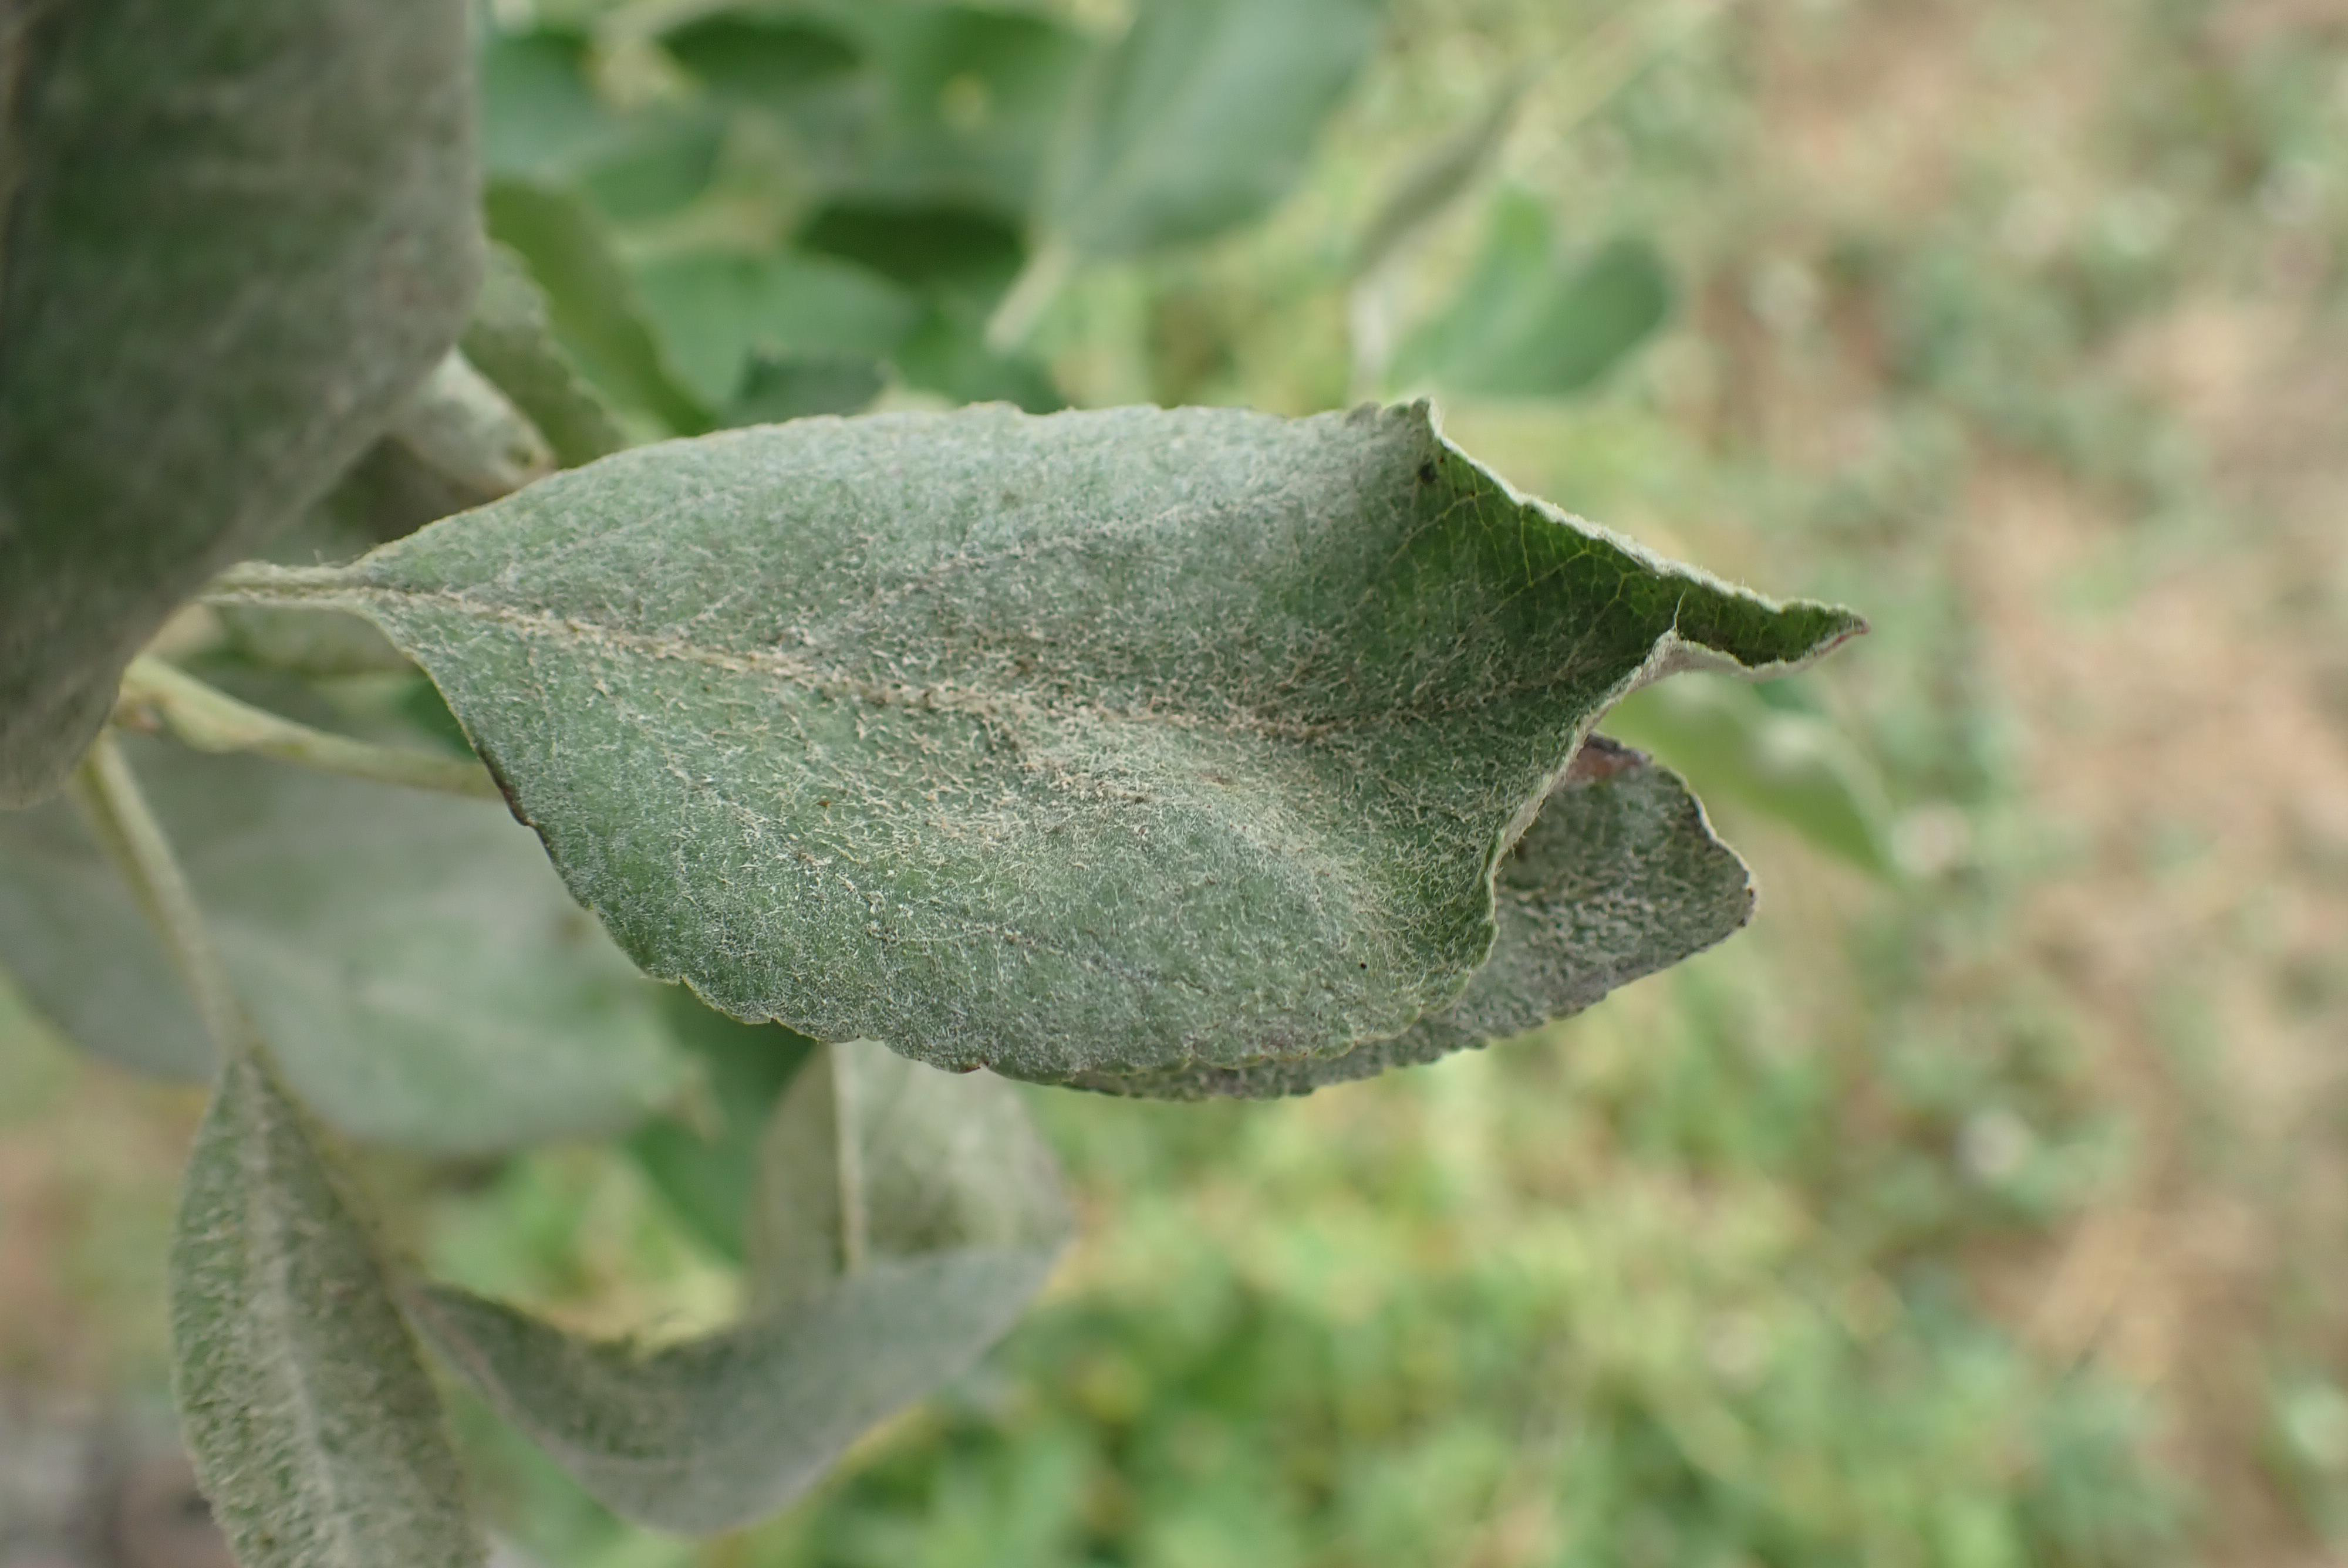

In [6]:
fname = Path(data_path/"train_images"/df.image[0])
im = Image.open(fname)
im

In [7]:
(data_path/"train_images").ls()

(#18632) [Path('../input/plant-pathology-2021-fgvc8/train_images/a8d54d0d96517ab3.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/ac6902fd1f0f3ce0.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/d4b7ea94e1c509e2.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/c780633f9d9d2970.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/a506c47f0f2d3d61.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/d4d8689596df6b80.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/edd8cfc45e503252.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/9ab326c1951acb7a.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/f728e036d729a0ad.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/fce318c6518fd20e.jpg')...]

### Function to load images and its label.

#### Set uf data block for image data with single class, split into train/validate (80/20%).

#### Presizeing: 
1) item_tfms - Resize images to relatively "large" dimensions (460) first before it is copied to the GPU. It used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the val set, the center square of the image is chosen.

2) batch_tfms - It's applied to a batch all at once on the GPU.With min_scale parameter in aug_transforms function, it will add RandomResizedCrop to a batch transform with a samller size.
Compose all of the common augmentation into one, and perform the combined operation on the GPU only once at the end of the processing. 

In [8]:
def get_x(r):  return data_path/"train_images"/r["image"]
def get_y(r):  return r["labels"]
f1_score_multi = F1Score(average="weighted")

In [9]:
plants = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x= get_x, 
                 splitter=RandomSplitter(seed=42),
                 get_y= get_y,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.5))

In [10]:
dls = plants.dataloaders(df,batch_size=64)

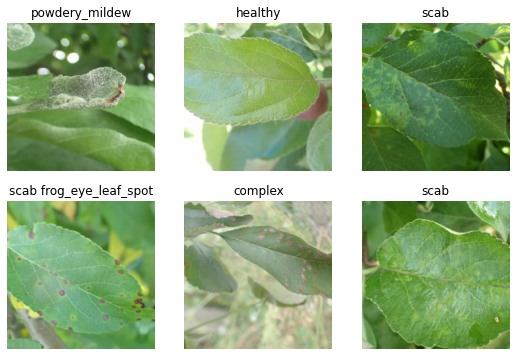

In [11]:
dls.show_batch(nrows=2, ncols =3)

In [12]:
learn = cnn_learner(dls, resnet50, metrics = [error_rate, f1_score_multi]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [13]:
learn.fine_tune(5,cbs=[EarlyStoppingCallback(patience=2),
                      SaveModelCallback()])

Better model found at epoch 0 with valid_loss value: 0.8286897540092468.


Better model found at epoch 0 with valid_loss value: 0.523165762424469.
Better model found at epoch 1 with valid_loss value: 0.44677627086639404.
Better model found at epoch 2 with valid_loss value: 0.3814809024333954.
Better model found at epoch 3 with valid_loss value: 0.3490031659603119.
Better model found at epoch 4 with valid_loss value: 0.34536153078079224.


 Now save the baseline model, and we can use it for inference in another notbook.

In [14]:
learn.export('resnet50_baseline.pkl')

# Turn off internet, load the trained model.

In [16]:
tst = get_image_files(data_path/'test_images')
test_dl = learn.dls.test_dl(tst)

In [17]:
preds = learn.get_preds(dl=test_dl) # get prediction

In [18]:
labels = np.argmax(to_np(preds[0]),1)
labels

array([0, 1, 9])